# Modelo de reconocimiento de letras

Por medio del uso del dataset que se encuentra en [keggle](https://www.kaggle.com/datasets/landlord/handwriting-recognition?resource=download), se desea construir un modelo de inteligencia artificial que proporcione la capacidad de analizar entrada de escritura a mano por medio de una entrada por mouse (Para esto se usará tensorflow.js que permite exportar el modelo para usarlo en el navegador de forma sencilla).

## Entrenamiento de dígitos

Para poder entrenar el modelo en el reconocimiento de letras individuales se usará la base de datos [EMNIST](https://www.kaggle.com/datasets/crawford/emnist?resource=download) lo cual nos ayudará a posteriormente entrenar el model en identificar las letras de cada uno de las palabras. Por lo cual será necesario el uso de los siguientes paquetes para crear y entrenar el modelo.

In [6]:
import os
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tf_keras import layers, losses, models, metrics, utils
DATASET_JONAS = "dataset/archive"
DATASET_JONAS2 = "dataset/second"
DATASET_EMNIST = "https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip"
np.set_printoptions(precision=3, suppress=True)

In [2]:
import pathlib
data_dir = utils.get_file(origin=DATASET_EMNIST, fname="emnist-letters", untar=True)
data_dir = pathlib.Path(data_dir)

  8396800/561753746 [..............................] - ETA: 3:36:09

KeyboardInterrupt: 

In [9]:
import gzip
import cv2
with gzip.open('dataset/gzip/emnist-letters-test-images-idx3-ubyte.gz', 'rb') as f:
    file_content = f.read()
    file_content = tf.data.Dataset.load(file_content)
file_content

TypeError: Can't mix strings and bytes in path components

### Funciones

Estas funciones nos ayudarán a poder realizar acciones que pueden ser repetidas varias veces, ya sea entrenando el modelo o incluso normalizando la información para poder entrenar al modelo.

In [12]:
def normalize(image):
    return image/255.

def norm(value, label):
    val = tf.cast(value, tf.float32)
    val = tf.expand_dims(val, axis=-1)
    return val, label

def grafic(modelo):
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.plot(modelo.history["loss"], label="Datos de entrenamiento")
    plt.plot(modelo.history["val_loss"], label="Datos de prueba")
    plt.legend(loc="upper right")
    plt.ylim([0,1])
    plt.show()

### Inicialización del modelo

Se necesita un modelo que pueda resolver los problemas de manera lineal, debido a que lo que siempre va a recibir es un vector unidimensional de 784 espacios, que es lo que se obtiene de una imagen de 28x28 píxeles. Además la principal función de activación que usan las capas ocultas son ReLU y softmax.

In [3]:
# Modelo
m = models.Sequential(layers=[
    layers.Flatten(input_shape=(784,)),
    layers.Dense(125, activation='relu'),
    layers.Dropout(0.03),
    layers.Dense(125, activation='relu'),
    layers.Dropout(0.03),
    layers.Dense(125, activation='relu'),
    layers.Dropout(0.03),
    layers.Dense(27, activation='softmax')])

m.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[metrics.SparseCategoricalAccuracy()])

In [7]:
df_train = pd.read_csv(os.path.join(DATASET_JONAS2, "emnist-letters-train.csv"), header=None)
df_train = df_train.sample(frac=1)
df_train_label = df_train.pop(0)
num_train = df_train.__len__()
df_train = df_train.map(normalize)
df_train

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
15744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_test = pd.read_csv(os.path.join(DATASET_JONAS2, "emnist-letters-test.csv"), header=None)
df_test = df_test.sample(frac=1)
df_test_label = df_test.pop(0)
df_test = df_test.map(normalize)
df_test

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
11473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
historial = m.fit(df_train, df_train_label, epochs=10, validation_data=[df_test, df_test_label])

Epoch 1/10


2024-05-07 20:15:20.147601: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 556953600 exceeds 10% of free system memory.
/home/jonasaray/Documents/UCAB/Decimo/Inteligencia artificial/Proyecto/LetterRecognition/venv/lib/python3.12/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2774/2775 [============================>.] - ETA: 0s - loss: 0.7686 - sparse_categorical_accuracy: 0.7639

/home/jonasaray/Documents/UCAB/Decimo/Inteligencia artificial/Proyecto/LetterRecognition/venv/lib/python3.12/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2775/2775 [==============================] - 18s 2ms/step - loss: 0.7685 - sparse_categorical_accuracy: 0.7639 - val_loss: 0.5184 - val_sparse_categorical_accuracy: 0.8299
Epoch 2/10
2775/2775 [==============================] - 5s 2ms/step - loss: 0.4408 - sparse_categorical_accuracy: 0.8590 - val_loss: 0.4147 - val_sparse_categorical_accuracy: 0.8618
Epoch 3/10
2775/2775 [==============================] - 5s 2ms/step - loss: 0.3719 - sparse_categorical_accuracy: 0.8772 - val_loss: 0.3809 - val_sparse_categorical_accuracy: 0.8726
Epoch 4/10
2775/2775 [==============================] - 5s 2ms/step - loss: 0.3326 - sparse_categorical_accuracy: 0.8893 - val_loss: 0.3638 - val_sparse_categorical_accuracy: 0.8805
Epoch 5/10
2775/2775 [==============================] - 5s 2ms/step - loss: 0.3061 - sparse_categorical_accuracy: 0.8967 - val_loss: 0.3694 - val_sparse_categorical_accuracy: 0.8799
Epoch 6/10
2775/2775 [==============================] - 5s 2ms/step - loss: 0.2855 - sparse_categori

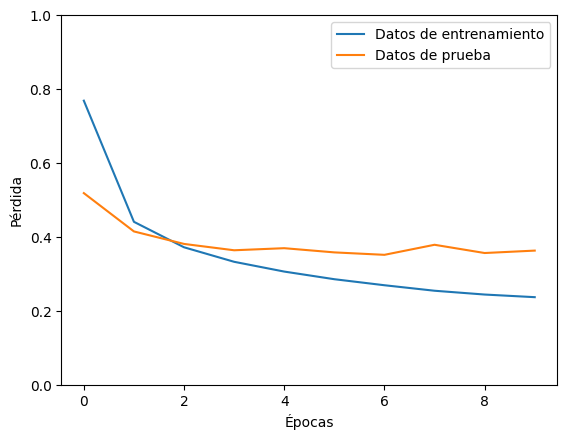

In [13]:
grafic(historial)

## Exportando el modelo

Una vez que el modelo haya sido entrenado ahora necesitamos exportarlo para hacer uso del mismo dentro del ámbito en desarrollo.

In [11]:
m.save(filepath="trainedModel/handwritting.h5")

/home/jonasaray/Documents/UCAB/Decimo/Inteligencia artificial/Proyecto/LetterRecognition/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Pruebas

Por medio de creación de imagenes podemos verificar que el modelo funciona como esperamos.

In [3]:
m = models.load_model("trainedModel/handwritting.h5")

In [6]:
prueba = m.predict(df_test)

2024-05-06 10:15:33.083017: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92825600 exceeds 10% of free system memory.


463/463 [==============================] - 5s 688us/step


In [11]:
LETTERS = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
index = np.argmax(prueba[1269])
print(LETTERS[index-1])

n


In [4]:
df_test_label

11269    15
3963      5
6619      9
11595    15
12143    16
         ..
701       1
4997      7
8554     11
10622    14
13429    17
Name: 0, Length: 14800, dtype: int64